# Cifar10 Image Classification Using DenseNet-121


## Basic import 

In [1]:
import tensorflow as tf
import fastestimator as fe
import matplotlib.pyplot as plt
import numpy as np

## Step1: Create FastEstimator `Pipeline`
### Load Dataset 
First, we load the training and evaluation dataset into memory use keras API.
   

In [2]:
(x_train, y_train), (x_eval, y_eval) = tf.keras.datasets.cifar10.load_data()
print("train image shape is {}".format(x_train.shape))
print("train label shape is {}".format(y_train.shape))
print("eval image shape is {}".format(x_eval.shape))
print("eval label shape is {}".format(y_eval.shape))

train image shape is (50000, 32, 32, 3)
train label shape is (50000, 1)
eval image shape is (10000, 32, 32, 3)
eval label shape is (10000, 1)


### Define `Pipeline`
`Pipeline` is the object that define how the training and evaulation data being ingested to the network.
It has three basic arguments: 
* **batch_size**: (int) The batch size 
* **data**: (dict) the data source. It should be the nested dictionary like {"mode1": {"feature1": numpy_array, "feature2": numpy_array, ...}, ...} 
* **ops**: (list, obj) The list of pipeline processs block. For this example, we only use Minmax, so it can be the object.  

In [3]:
from fastestimator.pipeline.processing import Minmax
batch_size = 64
data = {"train": {"x": x_train, 
                  "y": y_train}, 
        "eval": {"x": x_eval, 
                 "y": y_eval}}

pipeline = fe.Pipeline(batch_size=batch_size, data=data, ops=Minmax(inputs="x", outputs="x2"))

### Validate The Input Pipeline
Once the pipeline was created, it is better to validate it with pipeline method, **show_results**, which will return a sample batch of pipeline data that give you a clue of how it works.  

Because the pipeline has two different modes, "train" and "eval", we can take a looks of both examples.

the shape of train image batch is (64, 32, 32, 3)
the shape of train label batch is (64, 1)
the shape of eval image batch is (64, 32, 32, 3)
the shape of eval label batch is (64, 1)


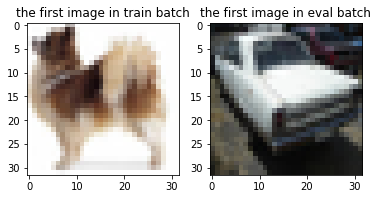

In [4]:
fig, ax = plt.subplots(1,2)
train_sample = pipeline.show_results(mode="train")
print("the shape of train image batch is {}".format(train_sample[0]["x"].numpy().shape))
print("the shape of train label batch is {}".format(train_sample[0]["y"].numpy().shape))
ax[0].imshow(train_sample[0]["x"].numpy()[0])
ax[0].set_title("the first image in train batch")
                
eval_sample = pipeline.show_results(mode="eval")
print("the shape of eval image batch is {}".format(eval_sample[0]["x"].numpy().shape))
print("the shape of eval label batch is {}".format(eval_sample[0]["y"].numpy().shape))
ax[1].imshow(eval_sample[0]["x"].numpy()[0])
ax[1].set_title("the first image in eval batch")
plt.show()

### Validate The Pipeline Output
There are totally three keys in the pipeline 
1. "y": the label
2. "x": the input image 
3. "x2": the processed output image.
In the previous example we only validate the input image. We still need to validate the processed output image, since it will be the actual input data source for the network after all. <br/>

The image process chain only has Minmax operation, which will map the minimum pixel value to 0 and maximum to 1.

In [5]:
print("In train_sample[\"x\"] the max is {}, the min is {}".format(np.max(train_sample[0]["x"].numpy()), np.min(train_sample[0]["x"].numpy())))
print("In train_sample[\"x2\"] the max is {}, the min is {}".format(np.max(train_sample[0]["x2"].numpy()), np.min(train_sample[0]["x2"].numpy())))
print("In eval_sample[\"x\"] the max is {}, the min is {}".format(np.max(eval_sample[0]["x"].numpy()), np.min(eval_sample[0]["x"].numpy())))
print("In eval_sample[\"x2\"] the max is {}, the min is {}".format(np.max(eval_sample[0]["x2"].numpy()), np.min(eval_sample[0]["x2"].numpy())))

In train_sample["x"] the max is 255, the min is 0
In train_sample["x2"] the max is 1.0, the min is 0.0
In eval_sample["x"] the max is 255, the min is 0
In eval_sample["x2"] the max is 1.0, the min is 0.0


## Step2: Create FastEstimator `Network` 
`Network` is the object that define the whole logic of neural network, including models, loss functions, optimizers ... etc. 
A Network can have several different models and loss funcitons (like GAN), but in this case, we are going to build a single model network.   

### Define Keras Model Function
The Model architecture of Fastestimator is defined by Tensorflow API (Keras). Here we used the pre-defined Keras function for building DensNet-121, and follow it by the custom layer to make it fit the Cifar10 dataset.   


In [6]:
from tensorflow.keras.applications.densenet import DenseNet121 
from tensorflow.keras.layers import Dense, Input

def DenseNet121_cifar10():
    inputs = Input((32,32,3))
    x = DenseNet121(weights=None, input_shape=(32,32,3), include_top=False, pooling='avg')(inputs)
    outputs = Dense(10, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

### Define `FEModel` from Keras
Here We build `FEModel` from Keras model function. It has four arguments:
* **model_def**: The model definition function.
* **model_name**: The name of the model. It will be used when storing the model. 
* **optimizer**: The optimizer. It can either be str or tf.optimizers object. 
* **loss_name**: The name of the loss. Pleas be aware it is the dictionary key name and will be used in `Network` definition.


In [7]:
from fastestimator.network.model import FEModel, ModelOp
from fastestimator.network.loss import SparseCategoricalCrossentropy

model = FEModel(model_def=DenseNet121_cifar10, 
                model_name="densenet121", 
                optimizer=tf.optimizers.Adam(lr=0.1), 
                loss_name="loss")

### Define `Network` from `FEMode`
So far we already have `FEmodel` and `Pipeline`, but how those networks connect to each other is still not defined yet.
`Network` API is created for this reason. Its input argument is a list of operations each have IO "keys". By sharing the keys, those operations can connect in the way you like.

In [8]:
network = fe.Network(ops=[
    ModelOp(inputs="x2", model=model, outputs="y_pred"), 
    SparseCategoricalCrossentropy(y_true="y", y_pred="y_pred", outputs="loss"),
])

The network will connect like the following graph 
<img src="network_workflow.png">

## Step 3: Create `Estimator` 
`Estimator` is the APi that wrap up the `Pipeline`, `Network` and other training metadata together.
The `Estimator` basically have 4 arguments:
* **pipeline**: the pipeline
* **network** the network
* **epoch** the epoch number of training
* **traces** the list of `trace` object. They are pretty like the callbacks of Keras. The trace object will be called on specific timing during the training. Here we used **Accuracy** for getting model accuracy, **ModelSaver** for saving the best model checkpoint, and **LRController** for adapting learning rate. 


In [30]:
import tempfile.mkdtemp()
from fastestimator.estimator.trace import Accuracy, ModelSaver, LRController, TensorBoard

save_dir = tempfile.mkdtemp()

estimator = fe.Estimator(
    network=network,
    pipeline=pipeline,
    epochs=50,
    traces=[
        Accuracy(true_key="y", pred_key="y_pred"),
        ModelSaver(model_name="densenet121", save_dir=save_dir, save_best=True),
        LRController(model_name="densenet121", reduce_on_eval=True)
    ])

## Start Training
We use `Estimator` method **fit** to train the model. 

In [ ]:
estimator.fit()

## Validate Model
After we trained the model, we might want to validate the model by running inference on evaluation datasets. Because FE so far doesn't support doing inference using estimator, We ues Keras API. 

First load the keras model (storing by **ModelSaver**)     

In [11]:
import os
model_path = os.path.join(save_dir, 'densenet121_best_loss.h5')
trained_model = tf.keras.models.load_model(model_path, compile=False)

Because the keras model doesn't include the data preprocessing pipeline, we cannot ingest the raw dataset to the model. Instead, we need to create the same pipeline again with batch size equal to whole evaluation dataset and feed the processed to the keras model. 

In [28]:
pipeline = fe.Pipeline(batch_size=10000, data=data, ops=Minmax(inputs="x", outputs="x2"))
eval_sample = pipeline.show_results(mode="eval")
x_input = eval_sample[0]["x2"].numpy()
y_input = eval_sample[0]["y"].numpy()
y_output = trained_model.predict(x_input)
y_predict = np.argmax(y_output, axis=1).reshape(10000,1)
print("the evaluation accuracy is {}".format(np.count_nonzero((y_input == y_predict))/10000))

the evaluation accuracy is 0.7518


Let's have a look as a random inference sample

the ground truth label is [1], and the prediction is [1]


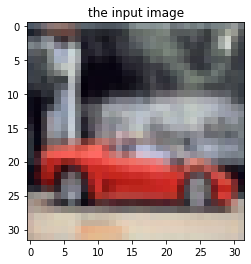

In [29]:
rand_int = np.random.randint(10000)
fig, ax = plt.subplots()
ax.imshow(x_input[rand_int])
ax.set_title("the input image")
print("the ground truth label is {}, and the prediction is {}".format(y_input[rand_int], y_predict[rand_int]))